In [ ]:
import requests, math, os
from collections import defaultdict
import pandas as pd

INTERPRO_URL = "https://www.ebi.ac.uk/interpro/api"
CATH_URL = f"https://www.cathdb.info/version/v4_3_0/api/rest/uniprot_to_funfam"

In [7]:
import requests, math, os
from collections import defaultdict
import pandas as pd

INTERPRO_URL = "https://www.ebi.ac.uk/interpro/api"
CATH_URL = f"https://www.cathdb.info/version/v4_3_0/api/rest/uniprot_to_funfam"


KNOWN_DATABASES = ["InterPro", "cathgene3d", "cdd", "HAMAP", "panther", "Pfam", "PIRSF", "PRINTS", "ssf", "antifam",
                        "PROSITE" "Patterns", "PROSITE", "profile", "smart", "SFLD", "SUPERFAMILY", "ncbifam"]
# ================================
# FINAL CONSOLIDATED FUNCTIONS
# ================================

def _get_protein_seq(uniprot_acc):
    """
    Fetch protein sequence from UniProt API.
    Returns tuple (sequence, length) or (None, -1) if not found.
    """
    url = f"https://rest.uniprot.org/uniprotkb/{uniprot_acc}.json"
    try:
        response = requests.get(url, timeout=30)
        response.raise_for_status()
        data = response.json()
        seq = data.get("sequence", {}).get("value")
        if seq:
            return seq, len(seq)
    except Exception as e:
        print(f"Error fetching data for {uniprot_acc}: {e}")
    return None, -1

# Helper function to extract domains from a specific source
def _extract_domains_from_source(uniprot_acc, source, representative_only=False):
    """
    Extract domains from a specific InterPro database source with pagination support.

    Parameters:
    -----------
    uniprot_acc : str
        UniProt accession
    source : str
        Database source ('pfam', 'smart', etc.)
    representative_only : bool
        If True, only return representative domain hits
    """
    url = f"{INTERPRO_URL}/entry/{source}/protein/UniProt/{uniprot_acc}?page_size=200"
    domains = []

    while url:
        try:
            response = requests.get(url, timeout=30)
            if response.status_code == 404:
                break
            response.raise_for_status()
            data = response.json()

            results = data.get("results", []) if isinstance(data, dict) else data

            for entry in results:
                # Get entry metadata
                meta = entry.get("metadata", {})
                entry_acc = meta.get("accession")
                entry_name = meta.get("name", "")
                entry_type = meta.get("type")
                source_db = meta.get("source_database")

                # Find target protein and extract coordinates
                for protein in entry.get("proteins", []):
                    protein_acc = protein.get("accession")
                    if protein_acc and protein_acc.upper() == uniprot_acc.upper():
                        # Check for matches (entry_protein_locations)
                        for location in protein.get("entry_protein_locations", []):
                            # KEY: representative flag is at the LOCATION level, not fragment level
                            is_representative = bool(location.get("representative"))

                            # KEY FILTER: Skip non-representative locations if filtering
                            if representative_only and not is_representative:
                                continue

                            for fragment in location.get("fragments", []):
                                # Skip domains with null/None/empty names
                                if entry_name and entry_name != '':
                                    domains.append({
                                        "accession": entry_acc,
                                        "name": entry_name,
                                        "type": entry_type,
                                        "source": source_db,
                                        "start": fragment.get("start"),
                                        "end": fragment.get("end"),
                                        "score": location.get("score"),
                                        "representative": is_representative
                                    })

            # Follow pagination
            url = data.get("next") if isinstance(data, dict) else None

        except requests.exceptions.RequestException:
            break

    return domains

def _get_interpro_domains(uniprot_acc, source=None, representative_only=False):
    """
    Get protein domain coordinates from InterPro API.

    Parameters:
    -----------
    uniprot_acc : str
        UniProt accession (e.g., 'P28482')
    source : str, list, or None
        - str: Query a specific database ('pfam', 'smart', 'prosite', etc.)
        - list: Query multiple specific databases (['pfam', 'smart'])
        - None: Query all available databases (default: representative hits only)
    representative_only : bool or None
        - True: Only return representative domain hits (reduces redundancy)
        - False: Return all hits
        - None: Auto-decide (True if source=None, False if source is specified)

    Returns:
    --------
    list of dict
        Each domain contains: accession, name, type, source, start, end, score, representative
        Sorted by start coordinate, then end coordinate
    """

    if source:
        # Handle list of databases
        if isinstance(source, list):
            all_domains = []
            available_dbs = []

            print(f"Querying specified databases for {uniprot_acc}: {', '.join(source)}")
            if representative_only:
                print("(filtering for representative hits only)")

            for db in source:
                domains = _extract_domains_from_source(uniprot_acc, db, representative_only)
                if domains:
                    available_dbs.append(f"{db}({len(domains)})")
                    all_domains.extend(domains)

            if available_dbs:
                print(f"Found data in: {', '.join(available_dbs)}")
            else:
                print(f"No data found in specified databases")

            # Sort by start, then end coordinate
            return sorted(all_domains, key=lambda x: (x["start"] if x["start"] is not None else float('inf'),
                                                       x["end"] if x["end"] is not None else float('inf')))

        # Handle single database (string)
        else:
            domains = _extract_domains_from_source(uniprot_acc, source, representative_only)
            # Sort by start, then end coordinate
            return sorted(domains, key=lambda x: (x["start"] if x["start"] is not None else float('inf'),
                                                   x["end"] if x["end"] is not None else float('inf')))

    else:
        # Query all known databases (default: representative only)
        all_domains = []
        available_dbs = []

        print(f"Scanning all databases for {uniprot_acc}...")
        if representative_only:
            print("(filtering for representative hits only)")

        for db in KNOWN_DATABASES:
            domains = _extract_domains_from_source(uniprot_acc, db, representative_only)
            if domains:
                available_dbs.append(f"{db}({len(domains)})")
                all_domains.extend(domains)

        print(f"Found data in: {', '.join(available_dbs)}")
        # Sort by start, then end coordinate
        return sorted(all_domains, key=lambda x: (x["start"] if x["start"] is not None else float('inf'),
                                                   x["end"] if x["end"] is not None else float('inf')))

def summarize_protein_domains_dict(uniprot_acc, source=None, representative_only=True):
    """
    Return a dict with protein name, domains (with coords and scores), and protein length.

    Parameters:
    -----------
    uniprot_acc : str
        UniProt accession
    source : str, list, or None
        - str: Query a specific database
        - list: Query multiple specific databases
        - None: Query all available databases
    representative_only : bool or None
        - True: Only return representative domain hits
        - False: Return all hits

    Returns:
    --------
    dict with keys: uniprot_acc, protein_length, domains (sorted by start coordinate), available_databases
    """
    # Get protein length
    seq, length = _get_protein_seq(uniprot_acc)
    if length <= 0:
        return None

    # Get domains (this will scan databases if source=None)
    # Domains are already sorted by get_interpro_domains
    domains = _get_interpro_domains(uniprot_acc, source=source, representative_only=representative_only)

    # Build available databases dict from domains already retrieved
    if source:
        if isinstance(source, list):
            databases = {}
            for domain in domains:
                db = domain.get('source')
                if db:
                    databases[db] = databases.get(db, 0) + 1
        else:
            databases = {source: len(domains)}
    else:
        # Extract database info from the domains we already have
        databases = {}
        for domain in domains:
            db = domain.get('source')
            if db:
                databases[db] = databases.get(db, 0) + 1

    # Build output dict
    result = {
        "uniprot_acc": uniprot_acc,
        "protein_length": length,
        "domains": domains,
        "available_databases": databases,
        "sequence": seq
    }
    return result


In [8]:
def compute_linker_regions(domains, protein_length=None):
    """
    Compute linker regions between domains.

    Parameters:
    -----------
    domains : list of dict
        List of domain dictionaries with 'start' and 'end' keys
        (e.g., result['domains'] from summarize_protein_domains_dict)
    protein_length : int, optional
        Total protein length. If provided, includes N-terminal and C-terminal regions.

    Returns:
    --------
    list of dict
        Each linker region contains: start, end
        Sorted by start coordinate
    """
    if not domains:
        if protein_length:
            return [{"start": 1, "end": protein_length}]
        return []

    # Sort domains by start position
    sorted_domains = sorted(domains, key=lambda x: (x["start"] if x["start"] is not None else float('inf')))

    linkers = []

    # Check for N-terminal linker (before first domain)
    first_domain = sorted_domains[0]
    if first_domain["start"] > 1:
        linker_start = 1
        linker_end = first_domain["start"] - 1
        # Only add if start < end (length > 0)
        if linker_start < linker_end:
            linkers.append({
                "start": linker_start,
                "end": linker_end
            })

    # Find gaps between consecutive domains
    for i in range(len(sorted_domains) - 1):
        current_domain = sorted_domains[i]
        next_domain = sorted_domains[i + 1]

        # Check if there's a gap between current domain end and next domain start
        gap_start = current_domain["end"] + 1
        gap_end = next_domain["start"] - 1

        # Only add if start < end (length > 0)
        if gap_start < gap_end:
            linkers.append({
                "start": gap_start,
                "end": gap_end
            })

    # Check for C-terminal linker (after last domain)
    if protein_length:
        last_domain = sorted_domains[-1]
        if last_domain["end"] < protein_length:
            linker_start = last_domain["end"] + 1
            linker_end = protein_length
            # Only add if start < end (length > 0)
            if linker_start < linker_end:
                linkers.append({
                    "start": linker_start,
                    "end": linker_end
                })

    return linkers

def add_linkers_to_result(result):
    """
    Add linker regions to a result dict from summarize_protein_domains_dict.

    Parameters:
    -----------
    result : dict
        Result dictionary from summarize_protein_domains_dict with keys:
        'domains', 'protein_length', etc.

    Returns:
    --------
    dict
        Same result dict with added 'linkers' key containing linker regions
    """
    linkers = compute_linker_regions(result['domains'], result.get('protein_length'))
    result['linkers'] = linkers
    return result


def get_linker_aa_count(linker, seq):
    """
    Count amino acids in a linker region.

    Parameters:
    -----------
    linker : dict
        Linker dictionary with 'start' and 'end' keys (1-indexed)
    seq : str
        Full protein sequence

    Returns:
    --------
    dict
        Dictionary with amino acid single-letter codes as keys and counts as values
    """
    from collections import Counter

    # Extract linker sequence (convert to 0-indexed)
    start = linker['start'] - 1
    end = linker['end']
    linker_seq = seq[start:end]

    # Count amino acids
    aa_count = Counter(linker_seq)

    return dict(aa_count)


def get_multiple_linkers_amino_acid_count(linker_seq_pairs):
    """
    Count amino acids across multiple linker regions.

    Parameters:
    -----------
    linker_seq_pairs : list of tuples
        List of (linker, seq) pairs where:
        - linker is a dict with 'start' and 'end' keys (1-indexed)
        - seq is the full protein sequence string

    Returns:
    --------
    dict
        Dictionary with amino acid single-letter codes as keys and total counts as values
    """
    from collections import Counter

    total_count = Counter()

    for linker, seq in linker_seq_pairs:
        linker_aa_count = get_linker_aa_count(linker, seq)
        total_count.update(linker_aa_count)

    return dict(total_count)


In [9]:
def format_protein_structure(result):
    """
    Format protein domain and linker data into simplified structure.

    Parameters:
    -----------
    result : dict
        Result from summarize_protein_domains_dict with linkers added

    Returns:
    --------
    dict with keys:
        - domains: list of tuples (domain_name, start, end)
        - linkers: list of tuples (type, length)
            where type is 'outer' for N/C-terminal or 'inner' for inter-domain
    """
    if not result:
        return None

    protein_length = result.get('protein_length')
    domains_list = result.get('domains', [])
    linkers_list = result.get('linkers', [])

    # Format domains as (name, start, end), excluding domains with null/None names
    formatted_domains = [
        (domain['name'], domain['start'], domain['end']) for domain in domains_list
        if domain.get('name') is not None and domain.get('name') != ''
    ]

    # Format linkers as (type, length)
    formatted_linkers = []
    for linker in linkers_list:
        start = linker['start']
        end = linker['end']
        length = end - start + 1

        # Determine if n-terminus, c-terminus, or inner (between domains)
        if start == 1:
            linker_type = 'n-terminus'
        elif end == protein_length:
            linker_type = 'c-terminus'
        else:
            linker_type = 'inner'

        formatted_linkers.append((linker_type, length))

    return {
        'uniprot_acc': result.get('uniprot_acc'),
        'domains': formatted_domains,
        'linkers': formatted_linkers
    }


In [20]:
import matplotlib.pyplot as plt

def analyze_linkers(proteins_dict, sequences_dict, domains):
    """
    Analyze linker amino acid composition.

    Parameters:
    -----------
    proteins_dict : dict
        Dictionary with protein accessions as keys and domain/linker info as values
    sequences_dict : dict
        Dictionary with protein accessions as keys and sequences as values
    domains : list
        List of protein domain data with linker coordinates

    Returns:
    --------
    tuple of (n_terminus_counter, c_terminus_counter, inner_counter, n_count, c_count, i_count,
              n_lengths, c_lengths, i_lengths)
        Three Counter objects with amino acid counts, the number of linkers for each type,
        and lists of lengths for each linker type
    """
    # Collect linkers by type with their sequences
    n_terminus_linkers = []
    c_terminus_linkers = []
    inner_linkers = []

    # Collect lengths for each linker type
    n_terminus_lengths = []
    c_terminus_lengths = []
    inner_lengths = []

    n_terminus_counter = Counter()
    c_terminus_counter = Counter()
    inner_counter = Counter()

    for accession, data in proteins_dict.items():
        linkers_formatted = data['linkers']  # This is list of (type, length) tuples

        protein_data = next((d for d in domains if d['uniprot_acc'] == accession), None)

        if protein_data:
            linkers_with_coords = protein_data['linkers']  # List of dicts with 'start' and 'end'
            seq = sequences_dict.get(accession)

            if seq and linkers_with_coords:
                # Match formatted linkers with coordinate linkers
                for i, linker_coord in enumerate(linkers_with_coords):
                    if i < len(linkers_formatted):
                        linker_type, linker_length = linkers_formatted[i]

                        if linker_type == 'n-terminus':
                            n_terminus_linkers.append((linker_coord, seq))
                            n_terminus_lengths.append(linker_length)
                        elif linker_type == 'c-terminus':
                            c_terminus_linkers.append((linker_coord, seq))
                            c_terminus_lengths.append(linker_length)
                        elif linker_type == 'inner':
                            inner_linkers.append((linker_coord, seq))
                            inner_lengths.append(linker_length)

    # Count amino acids for each linker type
    for linker, seq in n_terminus_linkers:
        aa_count = get_linker_aa_count(linker, seq)
        n_terminus_counter.update(aa_count)

    for linker, seq in c_terminus_linkers:
        aa_count = get_linker_aa_count(linker, seq)
        c_terminus_counter.update(aa_count)

    for linker, seq in inner_linkers:
        aa_count = get_linker_aa_count(linker, seq)
        inner_counter.update(aa_count)

    # Print statistics
    print(f"\nN-terminus amino acid counts ({len(n_terminus_linkers)} linkers):")
    print(dict(n_terminus_counter))
    print(f"\nC-terminus amino acid counts ({len(c_terminus_linkers)} linkers):")
    print(dict(c_terminus_counter))
    print(f"\nInner linker amino acid counts ({len(inner_linkers)} linkers):")
    print(dict(inner_counter))

    return (n_terminus_counter, c_terminus_counter, inner_counter,
            len(n_terminus_linkers), len(c_terminus_linkers), len(inner_linkers),
            n_terminus_lengths, c_terminus_lengths, inner_lengths)


def visualize_linker_composition(n_term_count, c_term_count, inner_count, n_count, c_count, i_count,
                                n_lengths=None, c_lengths=None, i_lengths=None, save_dir=None):
    """
    Create visualizations for linker amino acid composition.

    Parameters:
    -----------
    n_term_count : Counter
        Counter object with N-terminus amino acid counts
    c_term_count : Counter
        Counter object with C-terminus amino acid counts
    inner_count : Counter
        Counter object with inner linker amino acid counts
    n_count : int
        Number of N-terminus linkers analyzed
    c_count : int
        Number of C-terminus linkers analyzed
    i_count : int
        Number of inner linkers analyzed
    n_lengths : list, optional
        List of N-terminus linker lengths
    c_lengths : list, optional
        List of C-terminus linker lengths
    i_lengths : list, optional
        List of inner linker lengths
    save_dir : str, optional
        Directory to save plots. If None, plots are not saved.
    """
    import os

    # Create save directory if specified
    if save_dir:
        save_dir = os.path.expanduser(save_dir)
        os.makedirs(save_dir, exist_ok=True)
    # Prepare data for histograms
    amino_acids = sorted(set(list(n_term_count.keys()) +
                              list(c_term_count.keys()) +
                              list(inner_count.keys())))

    n_terminus_counts = [n_term_count.get(aa, 0) for aa in amino_acids]
    c_terminus_counts = [c_term_count.get(aa, 0) for aa in amino_acids]
    inner_counts = [inner_count.get(aa, 0) for aa in amino_acids]

    # Create side-by-side histograms for all three types
    _, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

    # N-terminus histogram
    ax1.bar(amino_acids, n_terminus_counts, color='steelblue', edgecolor='black')
    ax1.set_xlabel('Amino Acid', fontsize=12)
    ax1.set_ylabel('Count', fontsize=12)
    ax1.set_title(f'N-terminus Amino Acid Distribution\n({n_count} linkers)',
                  fontsize=14, fontweight='bold')
    ax1.grid(axis='y', alpha=0.3)

    # C-terminus histogram
    ax2.bar(amino_acids, c_terminus_counts, color='coral', edgecolor='black')
    ax2.set_xlabel('Amino Acid', fontsize=12)
    ax2.set_ylabel('Count', fontsize=12)
    ax2.set_title(f'C-terminus Amino Acid Distribution\n({c_count} linkers)',
                  fontsize=14, fontweight='bold')
    ax2.grid(axis='y', alpha=0.3)

    # Inner linkers histogram
    ax3.bar(amino_acids, inner_counts, color='mediumseagreen', edgecolor='black')
    ax3.set_xlabel('Amino Acid', fontsize=12)
    ax3.set_ylabel('Count', fontsize=12)
    ax3.set_title(f'Inner Linker Amino Acid Distribution\n({i_count} linkers)',
                  fontsize=14, fontweight='bold')
    ax3.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    if save_dir:
        plt.savefig(os.path.join(save_dir, 'individual_aa_distributions.png'), dpi=300, bbox_inches='tight')
    plt.show()

    # Calculate percentage composition (relative frequency)
    total_n = sum(n_terminus_counts)
    total_c = sum(c_terminus_counts)
    total_i = sum(inner_counts)

    n_terminus_pct = [(count / total_n * 100) if total_n > 0 else 0 for count in n_terminus_counts]
    c_terminus_pct = [(count / total_c * 100) if total_c > 0 else 0 for count in c_terminus_counts]
    inner_pct = [(count / total_i * 100) if total_i > 0 else 0 for count in inner_counts]

    # Create percentage composition comparison graph
    _, ax = plt.subplots(figsize=(16, 6))

    x = range(len(amino_acids))
    width = 0.25

    ax.bar([i - width for i in x], n_terminus_pct, width, label='N-terminus',
           color='steelblue', edgecolor='black')
    ax.bar([i for i in x], c_terminus_pct, width, label='C-terminus',
           color='coral', edgecolor='black')
    ax.bar([i + width for i in x], inner_pct, width, label='Inner',
           color='mediumseagreen', edgecolor='black')

    ax.set_xlabel('Amino Acid', fontsize=12)
    ax.set_ylabel('Percentage (%)', fontsize=12)
    ax.set_title('Amino Acid Percentage Composition: N-terminus vs C-terminus vs Inner Linkers',
                 fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(amino_acids)
    ax.legend()
    ax.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    if save_dir:
        plt.savefig(os.path.join(save_dir, 'percentage_aa_composition.png'), dpi=300, bbox_inches='tight')
    plt.show()

    # Create length distribution visualization if length data is provided
    if n_lengths is not None and c_lengths is not None and i_lengths is not None:
        import numpy as np

        # Calculate means
        n_mean = np.mean(n_lengths) if n_lengths else 0
        c_mean = np.mean(c_lengths) if c_lengths else 0
        i_mean = np.mean(i_lengths) if i_lengths else 0

        # Create box plot showing distribution with mean
        _, ax = plt.subplots(figsize=(10, 6))

        # Create box plot
        bp = ax.boxplot([n_lengths, c_lengths, i_lengths],
                        labels=['N-terminus', 'C-terminus', 'Inner'],
                        patch_artist=True,
                        showmeans=True,
                        meanprops=dict(marker='D', markerfacecolor='red', markeredgecolor='darkred',
                                      markersize=10, label='Mean'),
                        medianprops=dict(color='black', linewidth=2),
                        boxprops=dict(facecolor='lightblue', alpha=0.7),
                        whiskerprops=dict(linewidth=1.5),
                        capprops=dict(linewidth=1.5),
                        flierprops=dict(marker='o', markerfacecolor='gray', markersize=4, alpha=0.5))

        # Color the boxes differently for each linker type
        colors = ['steelblue', 'coral', 'mediumseagreen']
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)

        # Add mean values as text annotations
        means = [n_mean, c_mean, i_mean]
        stds = [np.std(n_lengths), np.std(c_lengths), np.std(i_lengths)]
        for i, (mean_val, std_val) in enumerate(zip(means, stds), 1):
            ax.text(i, mean_val, f'{mean_val:.1f}±{std_val:.1f}',
                   ha='left', va='center', fontsize=10, fontweight='bold',
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

        # Set y-axis limits to focus on the relevant range (exclude extreme outliers)
        # Calculate 95th percentile across all data to set upper limit
        all_lengths = n_lengths + c_lengths + i_lengths
        y_max = np.percentile(all_lengths, 95)
        y_min = 0
        ax.set_ylim(y_min, y_max * 1.1)  # Add 10% padding at top

        ax.set_ylabel('Length (amino acids)', fontsize=12)
        ax.set_xlabel('Linker Type', fontsize=12)
        ax.set_title('Linker Length Distributions with Mean and Standard Deviation',
                     fontsize=14, fontweight='bold')
        ax.grid(axis='y', alpha=0.3)

        # Add legend for mean marker
        ax.legend(['Mean'], loc='upper right')

        plt.tight_layout()
        if save_dir:
            plt.savefig(os.path.join(save_dir, 'mean_linker_lengths.png'), dpi=300, bbox_inches='tight')
        plt.show()

        # Print statistics
        n_median = np.median(n_lengths) if n_lengths else 0
        c_median = np.median(c_lengths) if c_lengths else 0
        i_median = np.median(i_lengths) if i_lengths else 0

        print(f"\n=== Linker Length Statistics ===")
        print(f"N-terminus: mean={n_mean:.1f}, median={n_median:.1f}, std={np.std(n_lengths):.1f}, n={len(n_lengths)}")
        print(f"C-terminus: mean={c_mean:.1f}, median={c_median:.1f}, std={np.std(c_lengths):.1f}, n={len(c_lengths)}")
        print(f"Inner:      mean={i_mean:.1f}, median={i_median:.1f}, std={np.std(i_lengths):.1f}, n={len(i_lengths)}")

Scanning all databases for P00742...
(filtering for representative hits only)
Found data in: cathgene3d(2), PIRSF(1), profile(1), smart(1)
Found data in: cathgene3d(2), PIRSF(1), profile(1), smart(1)
Scanning all databases for Q9Y6K9...
(filtering for representative hits only)
Scanning all databases for Q9Y6K9...
(filtering for representative hits only)
Found data in: cathgene3d(3), panther(1), Pfam(1), profile(1)
Found data in: cathgene3d(3), panther(1), Pfam(1), profile(1)
Scanning all databases for P0A7W1...
(filtering for representative hits only)
Scanning all databases for P0A7W1...
(filtering for representative hits only)
Found data in: HAMAP(1)
Found data in: HAMAP(1)
Scanning all databases for P69905...
(filtering for representative hits only)
Scanning all databases for P69905...
(filtering for representative hits only)
Found data in: panther(1), ssf(1)
Found data in: panther(1), ssf(1)
Scanning all databases for P68366...
(filtering for representative hits only)
Scanning all d

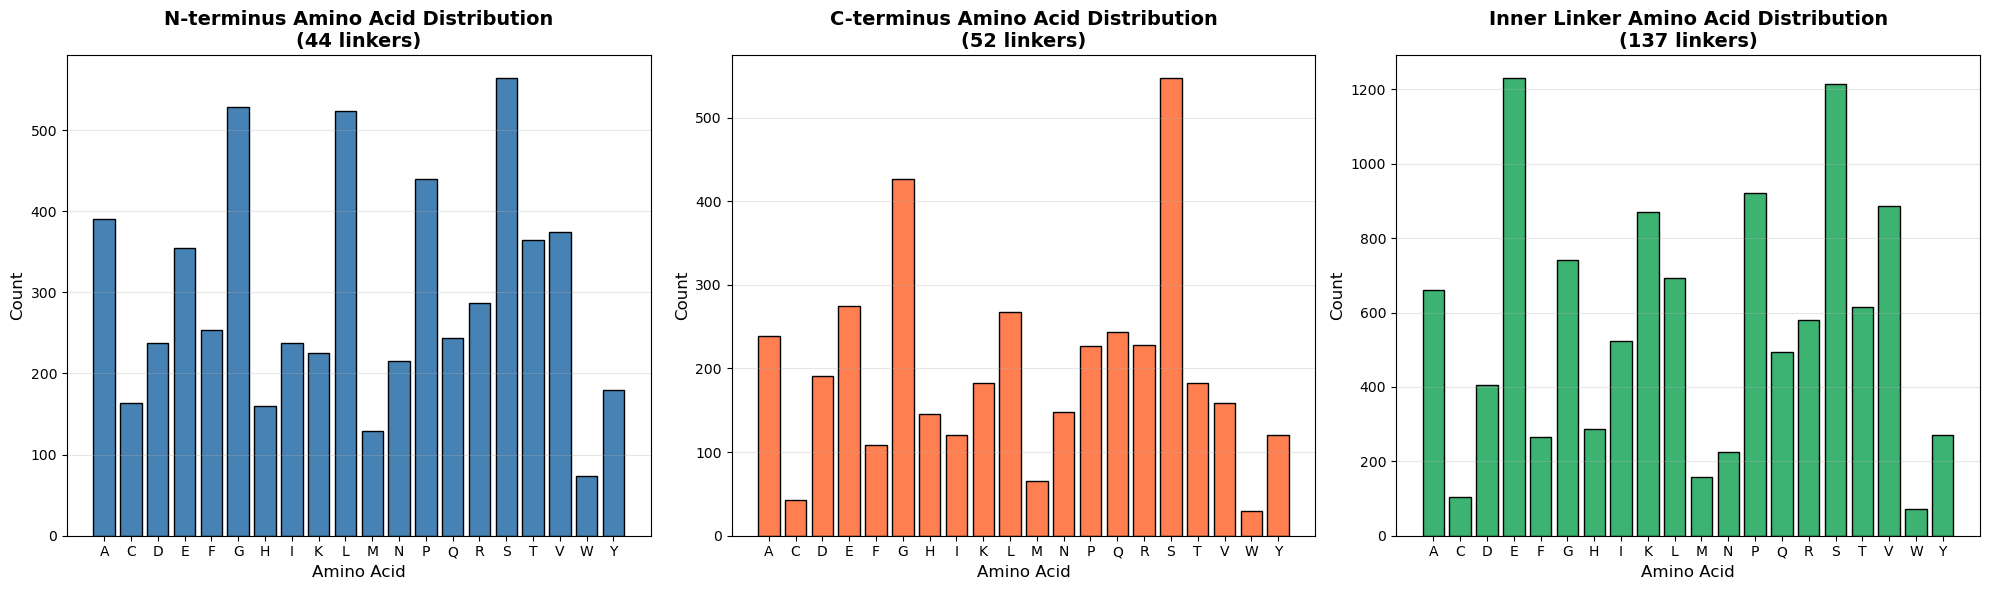

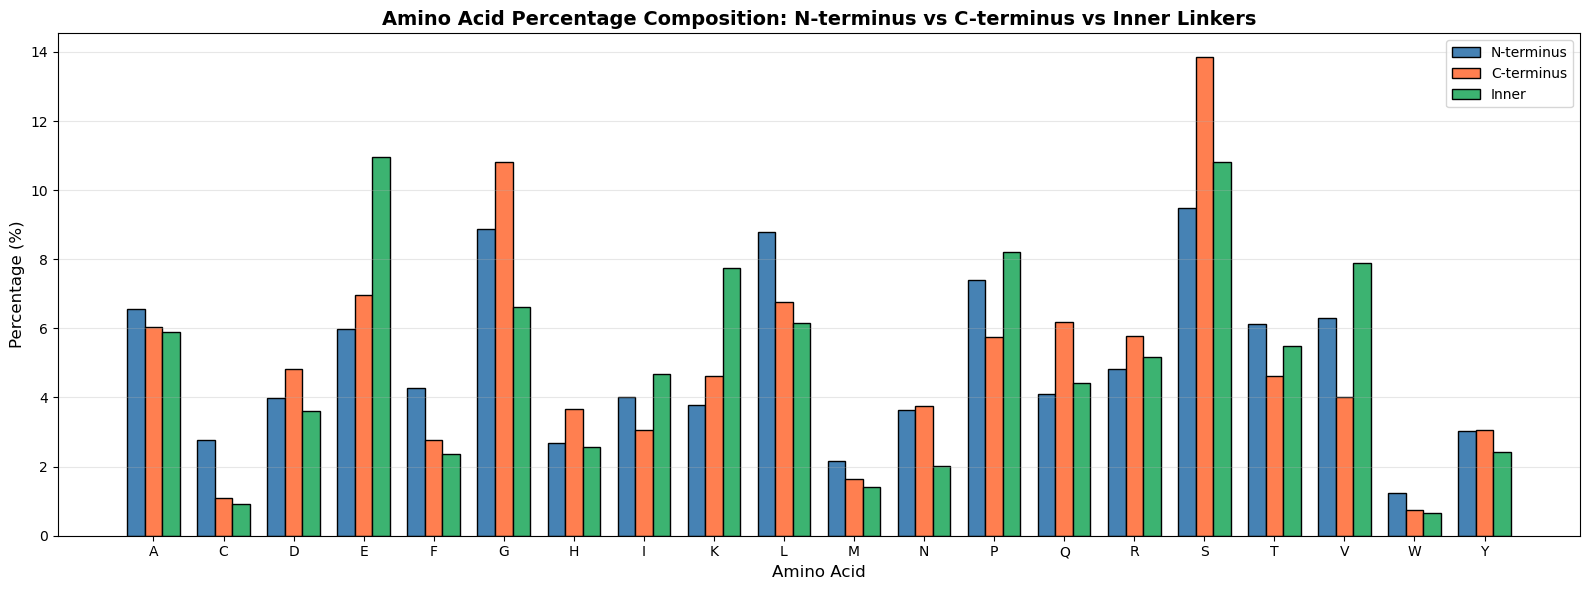

/tmp/ipykernel_1541/2240497433.py:212: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot([n_lengths, c_lengths, i_lengths],


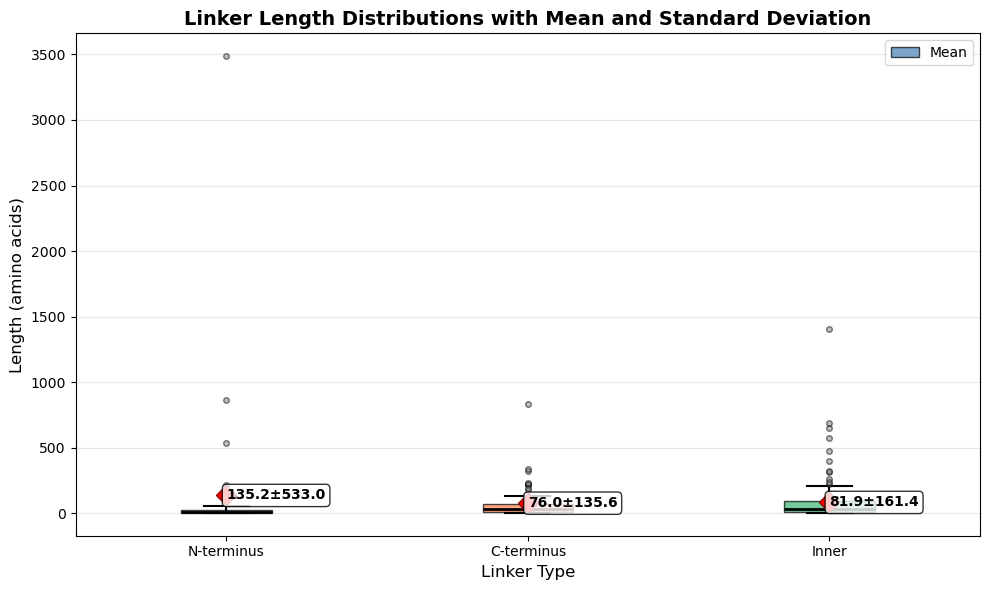


=== Linker Length Statistics ===
N-terminus: mean=135.2, median=9.0, std=533.0, n=44
C-terminus: mean=76.0, median=28.5, std=135.6, n=52
Inner:      mean=81.9, median=30.0, std=161.4, n=137


In [ ]:
import requests, math, os, json
from collections import defaultdict, Counter
import pandas as pd


workdir = "~/Desktop/work/protein_linkers"
protein_file = os.path.expanduser(f"{workdir}/proteins.tsv")
protein_df = pd.read_csv(protein_file, sep="\t")
protein_list = list(set(protein_df["Accession"].to_list()))
fasta_path = os.path.expanduser(f"{workdir}/proteins.fa")
domains = []

with open(fasta_path, 'w') as f:
    for protein in protein_list:
        seq, _ = _get_protein_seq(protein)
        if seq:
            f.write(f">{protein}\n{seq}\n")
        res = summarize_protein_domains_dict(protein, source=None, representative_only=True)
        if res:
            add_linkers_to_result(res)
            domains.append(res)

print(f"Wrote {len(protein_list)} sequences to {fasta_path}")
print(domains)

for accession in domains:
    add_linkers_to_result(accession)
    if len(accession["linkers"]) > 0:
        print(accession["linkers"])

# Apply to all proteins in the domains list
formatted_proteins = []
for protein_data in domains:
    formatted = format_protein_structure(protein_data)
    if formatted:
        formatted_proteins.append(formatted)

# Display the results
for protein in formatted_proteins:
    print(f"\nProtein: {protein['uniprot_acc']}")
    print(f"Domains: {protein['domains']}")
    print(f"Linkers: {protein['linkers']}")


import json
import os

# Save formatted_proteins to a JSON file
output_file = os.path.join(os.path.expanduser(workdir), "formatted_proteins.json")

# Convert to a dict with uniprot_acc as keys for easy lookup
formatted_proteins_dict = {
    protein['uniprot_acc']: {
        'domains': protein['domains'],
        'linkers': protein['linkers']
    }
    for protein in formatted_proteins
}

# Save to file
with open(output_file, 'w') as f:
    json.dump(formatted_proteins_dict, f, indent=2)

print(f"\nSaved {len(formatted_proteins_dict)} proteins to {output_file}")
print(f"File size: {os.path.getsize(output_file)} bytes")

from collections import Counter

output_file = os.path.join(os.path.expanduser(workdir), "formatted_proteins.json")

with open(output_file, 'r') as f:
    proteins_dict = json.load(f)

print(f"Loaded {len(proteins_dict)} proteins from {output_file}")

# Load FASTA file as dictionary
sequences_dict = {}
with open(fasta_path, 'r') as f:
    current_acc = None
    current_seq = []
    for line in f:
        line = line.strip()
        if line.startswith('>'):
            # Save previous sequence if exists
            if current_acc:
                sequences_dict[current_acc] = ''.join(current_seq)
            # Start new sequence
            current_acc = line[1:]
            current_seq = []
        else:
            # Append sequence line
            current_seq.append(line)
    # Save last sequence
    if current_acc:
        sequences_dict[current_acc] = ''.join(current_seq)

print(f"Loaded {len(sequences_dict)} sequences from {fasta_path}")



N-terminus amino acid counts (44 linkers):
{'M': 129, 'G': 528, 'R': 287, 'N': 216, 'H': 160, 'L': 523, 'W': 74, 'K': 225, 'S': 564, 'Q': 244, 'C': 164, 'E': 355, 'V': 374, 'P': 440, 'A': 390, 'D': 237, 'T': 365, 'F': 254, 'I': 238, 'Y': 180}

C-terminus amino acid counts (52 linkers):
{'T': 183, 'R': 228, 'G': 427, 'L': 267, 'P': 227, 'K': 183, 'A': 239, 'S': 547, 'H': 145, 'E': 275, 'V': 159, 'I': 121, 'Q': 244, 'D': 191, 'F': 109, 'N': 148, 'C': 43, 'M': 65, 'Y': 121, 'W': 29}

Inner linker amino acid counts (137 linkers):
{'R': 580, 'K': 870, 'S': 1214, 'V': 886, 'A': 661, 'Q': 495, 'T': 615, 'G': 742, 'E': 1230, 'P': 922, 'D': 405, 'I': 524, 'W': 73, 'Y': 272, 'L': 692, 'N': 226, 'F': 266, 'H': 287, 'C': 104, 'M': 157}


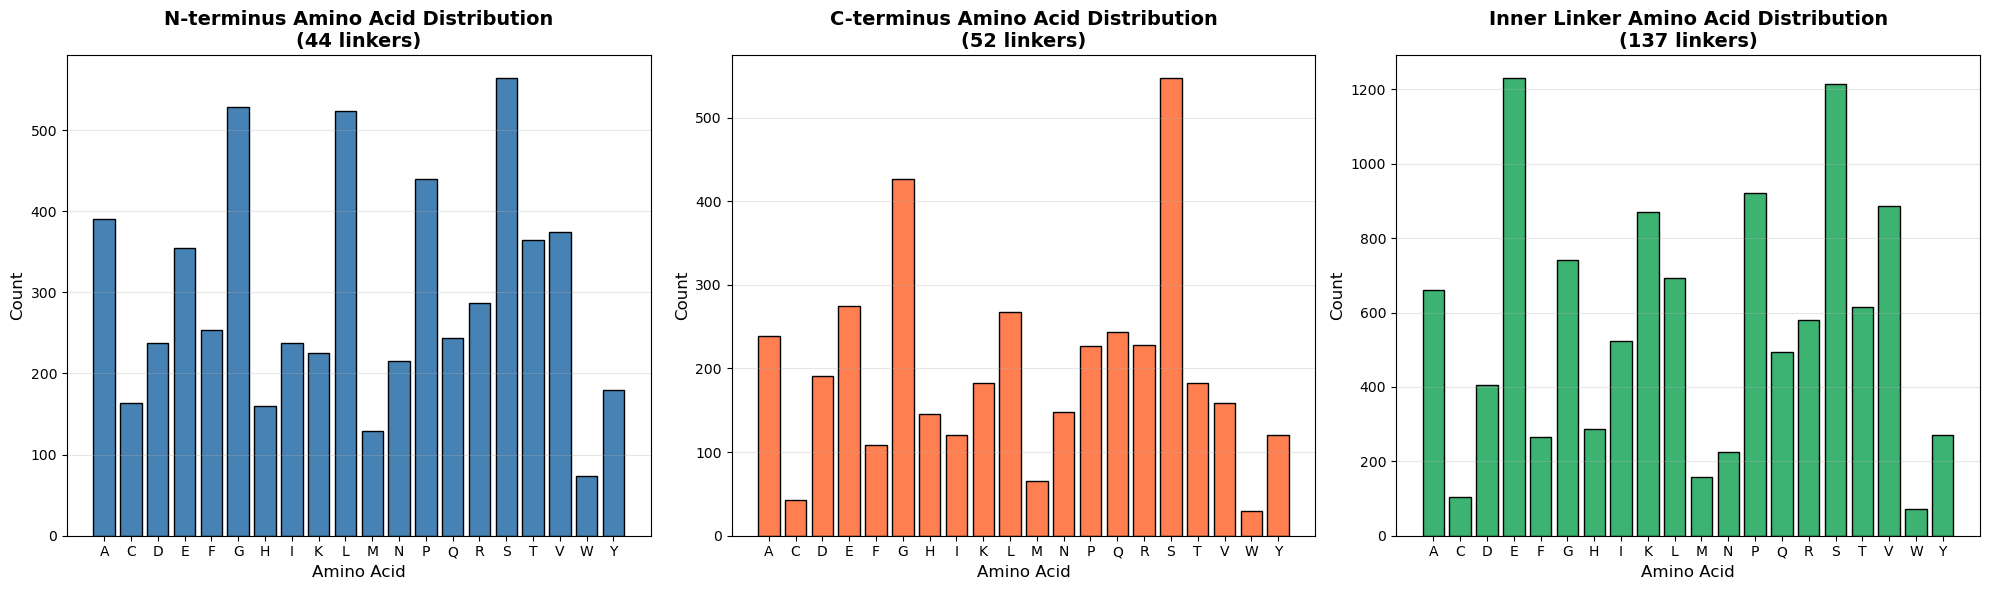

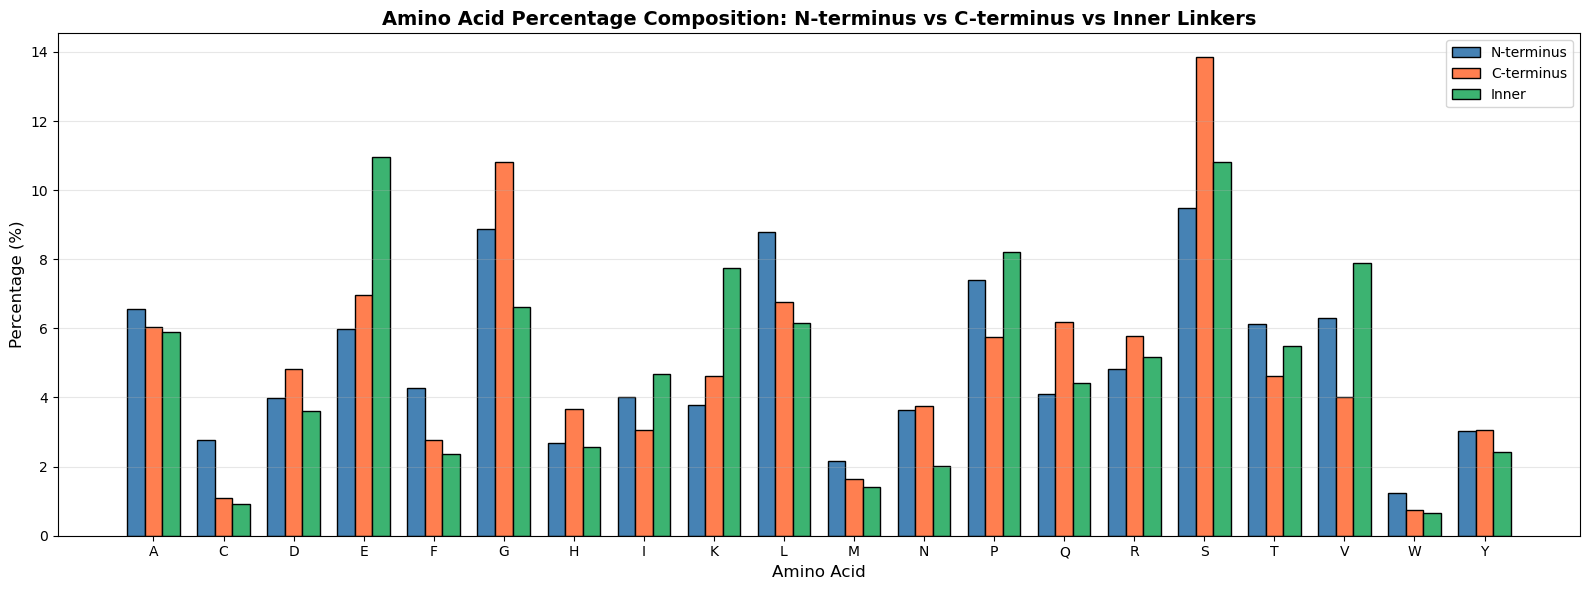

/tmp/ipykernel_1541/3325682616.py:212: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot([n_lengths, c_lengths, i_lengths],


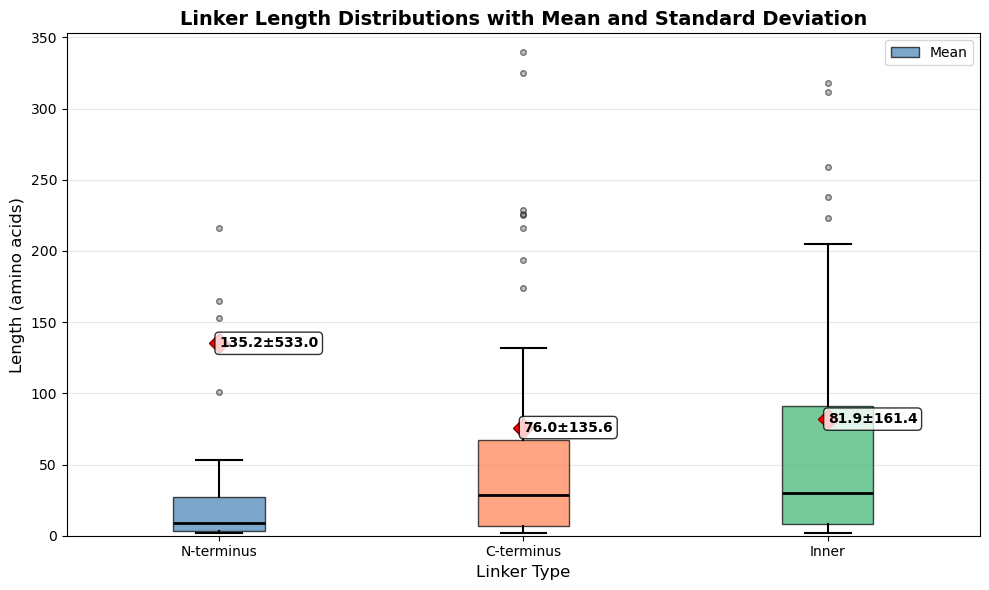


=== Linker Length Statistics ===
N-terminus: mean=135.2, median=9.0, std=533.0, n=44
C-terminus: mean=76.0, median=28.5, std=135.6, n=52
Inner:      mean=81.9, median=30.0, std=161.4, n=137


In [21]:
# Run the analysis
n_terminus_counter, c_terminus_counter, inner_counter, n_count, c_count, i_count, n_lengths, c_lengths, i_lengths = analyze_linkers(
    proteins_dict, sequences_dict, domains
)

# Create visualizations and save them
visualize_linker_composition(n_terminus_counter, c_terminus_counter, inner_counter, n_count, c_count, i_count, n_lengths, c_lengths, i_lengths, save_dir=workdir)


In [ ]:
def cath_gene3d(uniprot_acc):
    """
    Pull CATH FunFams for a UniProt and infer domain spans if present.
    (Some responses include mapped regions to the sequence.)
    """
    url = f"{CATH_URL}/{uniprot_acc}?content-type=application/json"
    r = requests.get(url, timeout=30)
    if r.status_code == 404:
        return []
    r.raise_for_status()
    data = r.json()
    hits = []
    for ff in data.get("data", []) if isinstance(data, dict) else data:
        sfam = ff.get("superfamily_id")
        funfam = ff.get("funfam_number")
        for reg in ff.get("regions", []):
            hits.append({
                "db": "CATH-Gene3D",
                "accession": f"{sfam}/FF{funfam}",
                "start": reg.fet("aln_start") or reg.get("start"),
                "end": reg.get("aln_end") or reg.get("end"),
                "score": reg.get("evalue") or reg.get("bitscore")
            })
    return sorted([h for h in hits if h["start"] and h["end"]], key=lambda h: (h["start"], h["end"]))
